In [1]:
## The purpose of this notebook is to use the validation matrix counts data to run through the gi calling analysis pipeline and then 
## determine which of the spiked in predicted interacting genes validate

## Plots generated using this notebook appear in Figure 6A&B and S5D-J


In [1]:
## Import modules

import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
from scipy import stats
import seaborn as sns

In [20]:
####Analysis pipeline####

## ALL THAT FOLLOWS IN THIS CELL WAS CREATED BY MAX HORLBECK

#version that only filters based on cycledCol as many sgRNAs have median rep of 0 at the end
def calcLog2e_cycledonly(t0Col, cycledCol, doublesTable, filterThreshold = 1.0, pseudocount = 1.0, doublingDifferences = 1.0):
    meanCounts = pd.concat((cycledCol.groupby(doublesTable['name_a']).agg(np.median),cycledCol.T.groupby(doublesTable['name_b']).agg(np.median)), keys=['a','b'])
    
    sgsToFilter = set(meanCounts.loc[meanCounts.loc[:,'b'] < filterThreshold].index).union(set(meanCounts.loc[meanCounts.loc[:,'a'] < filterThreshold].index))
    doublesTable_filt = doublesTable.loc[doublesTable.apply(lambda row: row['name_a'] not in sgsToFilter and row['name_b'] not in sgsToFilter, axis=1)]
    print(str(len(doublesTable_filt)) + ' pairs of ' + str(len(doublesTable)) + ' passing filter')
    
    countsRatio = (t0Col.loc[doublesTable_filt.index] + pseudocount).sum()*1.0/(cycledCol.loc[doublesTable_filt.index] + pseudocount).sum()
    log2es = np.log2((cycledCol.loc[doublesTable_filt.index] + pseudocount)/(t0Col.loc[doublesTable_filt.index] + pseudocount)/countsRatio)

    doubleNegatives = doublesTable.apply(lambda row: row['gene_a'] == 'negative' and row['gene_b'] == 'negative', axis=1)

    log2es -= log2es.loc[doubleNegatives].median()

    log2es /= doublingDifferences
    
    return log2es

#for a specified variable position and sgRNA, get single phenotypes, double phenotypes, and optionally single phenotype std dev.
def getXYB(sgRNA, singlePhenotypes, phenotypeMatrix, variablePosition, fixedPosition, returnXerr=False):
    if not returnXerr:
        return singlePhenotypes[variablePosition+'.mean'], \
            phenotypeMatrix.loc[sgRNA,:] if fixedPosition == 'a' else phenotypeMatrix.loc[:,sgRNA], \
            singlePhenotypes.loc[sgRNA, fixedPosition +'.mean']
    else:
        return singlePhenotypes[variablePosition+'.mean'], \
            phenotypeMatrix.loc[sgRNA,:] if fixedPosition == 'a' else phenotypeMatrix.loc[:,sgRNA], \
            singlePhenotypes.loc[sgRNA, fixedPosition +'.mean'], singlePhenotypes[variablePosition+'.std']
        
#convert phenotypes into square matrix
def generatePhenotypeMatrix(phenotypes):
    numSingles = int(np.sqrt(len(phenotypes)))
    phenotypeMatrix = np.zeros((numSingles,numSingles))
    singlesTable = []
    for i, (sgPair, counts) in enumerate(phenotypes.sort_index().items()):
        phenotypeMatrix[int(i/numSingles), i%numSingles] = counts
        if i%numSingles == 0:
            singlesTable.append(sgPair.split(':')[0])

    phenotypeMatrix = pd.DataFrame(phenotypeMatrix, index=singlesTable, columns=singlesTable)
    singlesTable = pd.DataFrame([s.split('_')[0] for s in singlesTable], index=singlesTable, columns=['gene'])
    
    singlePhenotypes = pd.concat((phenotypeMatrix.loc[singlesTable['gene'] == 'non-targeting',:].apply(np.nanmean, axis=0), 
                                  phenotypeMatrix.loc[singlesTable['gene'] == 'non-targeting',:].apply(np.nanstd, axis=0), 
                                  phenotypeMatrix.loc[:, singlesTable['gene'] == 'non-targeting'].apply(np.nanmean, axis=1),
                                 phenotypeMatrix.loc[:, singlesTable['gene'] == 'non-targeting'].apply(np.nanstd, axis=1)), 
                                 axis=1, keys=['b.mean','b.std','a.mean','a.std'])
    
    return phenotypeMatrix, singlesTable, singlePhenotypes

def abbaAveragePhenotypes(phenotypeMatrix, singlesTable):
	phenotypeMatrix_abba = (phenotypeMatrix + phenotypeMatrix.T) / 2

	singlePhenotypes_abba = pd.concat((phenotypeMatrix_abba.loc[singlesTable['gene'] == 'non-targeting',:].apply(np.nanmean, axis=0), 
                                  phenotypeMatrix_abba.loc[singlesTable['gene'] == 'non-targeting',:].apply(np.nanstd, axis=0), 
                                  phenotypeMatrix_abba.loc[:, singlesTable['gene'] == 'non-targeting'].apply(np.nanmean, axis=1),
                                  phenotypeMatrix_abba.loc[:, singlesTable['gene'] == 'non-targeting'].apply(np.nanstd, axis=1)), 
                                 axis=1, keys=['b.mean','b.std','a.mean','a.std'])

	return phenotypeMatrix_abba, singlePhenotypes_abba


#calculate epistasis interactions, optionally z-standardizing based on negative controls
def calculateInteractions(phenotypeMatrix, singlePhenotypes, singlesTable, fitFunction, zstandardize=True):
    emap1 = pd.DataFrame(np.zeros(phenotypeMatrix.shape), index=phenotypeMatrix.index, columns=phenotypeMatrix.columns)
    variablePosition, fixedPosition = 'a','b'
    for i, sgRNA in enumerate(phenotypeMatrix.index):
        xdata, ydata, bdata = getXYB(sgRNA, singlePhenotypes, phenotypeMatrix, variablePosition, fixedPosition)
        
        fit = fitFunction(xdata, ydata, bdata)
        epistasis = ydata - fit(xdata)

        if zstandardize:
	        emap1.loc[sgRNA,:] = epistasis / epistasis.loc[singlesTable['gene'] == 'non-targeting'].std()
       	else:
	        emap1.loc[sgRNA,:] = epistasis 

    emap2 = pd.DataFrame(np.zeros(phenotypeMatrix.shape), index=phenotypeMatrix.index, columns=phenotypeMatrix.columns)
    variablePosition, fixedPosition = 'b','a'
    for i, sgRNA in enumerate(phenotypeMatrix.index):
        xdata, ydata, bdata = getXYB(sgRNA, singlePhenotypes, phenotypeMatrix, variablePosition, fixedPosition)
        
        fit = fitFunction(xdata, ydata, bdata)
        epistasis = ydata - fit(xdata)

        if zstandardize:
	        emap2.loc[sgRNA,:] = epistasis / epistasis.loc[singlesTable['gene'] == 'non-targeting'].std()
       	else:
	        emap2.loc[sgRNA,:] = epistasis 

    emap12 = (emap1+emap2)/2
    
    emap_ave = (emap12 + emap12.T) / 2
    
    return emap1, emap2, emap_ave

#calculate all pairwise intra-sgRNA or intra-gene correlations
def calculateCorrelationMatrix(matrix, diagNull=True):
    corrMatrix = pd.DataFrame(np.corrcoef(matrix), index=matrix.index, columns=matrix.columns)
    
    if diagNull:
        for i in range(len(corrMatrix)):
            corrMatrix.iloc[i,i] = np.nan
            
    return corrMatrix

#find correlations between sgRNAs targeting the same gene and negative controls
def calculateIntrageneCorrelation(sgCorrMatrix, singlePhenotypes, singlesTable):
    sameGeneCorrTups = []
    negCorrTups = []
    for gene, sgs in singlesTable.groupby('gene'):
        for i, (sg1, row) in enumerate(sgCorrMatrix.loc[sgs.index, sgs.index].iterrows()):
            for j, (sg2, val) in enumerate(row.items()):
                if i>j:
                    if gene != 'negative':
                        sameGeneCorrTups.append((sg1, sg2, 
                                                 singlePhenotypes.loc[sg1,['a.mean','b.mean']].mean(), 
                                                 singlePhenotypes.loc[sg2,['a.mean','b.mean']].mean(),
                                                val))
                    else:
                        negCorrTups.append((sg1, sg2, 
                                                 singlePhenotypes.loc[sg1,['a.mean','b.mean']].mean(), 
                                                 singlePhenotypes.loc[sg2,['a.mean','b.mean']].mean(),
                                                val))
                        
    return sameGeneCorrTups, negCorrTups


#generate a gene map by averaging sgRNA epistasis
def generateGeneMap(emap_sgRNA, singlesTable):
    emap_gene = pd.DataFrame(np.zeros((len(set(singlesTable['gene'])),len(set(singlesTable['gene'])))), index = sorted(set(singlesTable['gene'])), columns = sorted(set(singlesTable['gene'])))
    for gene_a, rowgroup in emap_sgRNA.groupby(singlesTable['gene']):
        for gene_b, colgroup in rowgroup.T.groupby(singlesTable['gene']):
            emap_gene.loc[gene_a, gene_b] = colgroup.sum().sum() / (colgroup.shape[0] * colgroup.shape[1])
            
    return emap_gene

### fit functions for calculating interactions and plotting
def linearFitForceIntercept(xdata, ydata, bdata):
    m1 = optimize.fmin(lambda m, x, y: ((m*x + bdata - y)**2).sum(), x0=0.1, args=(xdata, ydata), disp=0)[0]
    
    return lambda x1: m1*np.array(x1) + bdata

def quadFitForceIntercept(xdata, ydata, bdata):
    m1 = optimize.fmin(lambda m, x, y: ((m[0]*(x**2) + m[1]*x + bdata - y)**2).sum(), x0=[0.1,0.1], args=(xdata, ydata), disp=0)
    
    return lambda x1: m1[0]*(np.array(x1)**2) + m1[1]*np.array(x1) + bdata


In [12]:
## Corrected version of Max's function for calling phenotypes

def calcLog2e_cycledonly_corrected(t0Col, cycledCol, doublesTable, filterThreshold = 1.0, pseudocount = 1.0, doublingDifferences = 1.0):
    meanCounts = pd.concat((cycledCol.groupby(doublesTable['name_a']).agg('median'),cycledCol.groupby(doublesTable['name_b']).agg('median')),axis=1, keys=['a','b'])
    
    sgsToFilter = set(meanCounts.loc[meanCounts.loc[:,'b'] < filterThreshold].index).union(set(meanCounts.loc[meanCounts.loc[:,'a'] < filterThreshold].index))
    doublesTable_filt = doublesTable.loc[doublesTable.apply(lambda row: row['name_a'] not in sgsToFilter and row['name_b'] not in sgsToFilter, axis=1)]
    print(str(len(doublesTable_filt)) + ' pairs of ' + str(len(doublesTable)) + ' passing filter')
    
    countsRatio = (t0Col.loc[doublesTable_filt.index] + pseudocount).sum()*1.0/(cycledCol.loc[doublesTable_filt.index] + pseudocount).sum()
    log2es = np.log2(((cycledCol.loc[doublesTable_filt.index] + pseudocount)/(t0Col.loc[doublesTable_filt.index] + pseudocount))*countsRatio)

    doubleNegatives = doublesTable.apply(lambda row: row['gene_a'] == 'non-targeting' and row['gene_b'] == 'non-targeting', axis=1)

    log2es -= log2es.loc[doubleNegatives].median()

    log2es /= doublingDifferences
    
    return log2es



In [25]:
## Import data

## files need are counts data and library from the validation screen available at: 
## https://ucsf.box.com/s/nuwov4kgb55mqfrr7j5a216ot78f4uxn
## these should be used to define these variables accordingly:

#countsFile = pd.read_csv('../validation_screen_counts.csv',index_col = 0).set_index('double')
#doublesLibrary = pd.read_csv('../validation_screen_library',index_col = 0).set_index('double')



## Import the original GI maps
og_dmso1_map = pd.read_excel('/Users/benh/Desktop/UCSF_Tetrad_Program/Gilbert_Lab/herken2023_materials/figures/herken23_supp_data/Data_S3.xlsx',index_col = 0)
og_atr_map = pd.read_excel('/Users/benh/Desktop/UCSF_Tetrad_Program/Gilbert_Lab/herken2023_materials/figures/herken23_supp_data/Data_S4.xlsx',index_col = 0)
og_dmso2_map = pd.read_excel('/Users/benh/Desktop/UCSF_Tetrad_Program/Gilbert_Lab/herken2023_materials/figures/herken23_supp_data/Data_S6.xlsx',index_col = 0)
og_etop_map = pd.read_excel('/Users/benh/Desktop/UCSF_Tetrad_Program/Gilbert_Lab/herken2023_materials/figures/herken23_supp_data/Data_S7.xlsx',index_col = 0)
og_keto_map = pd.read_excel('/Users/benh/Desktop/UCSF_Tetrad_Program/Gilbert_Lab/herken2023_materials/figures/herken23_supp_data/Data_S8.xlsx',index_col = 0)

## Import phenotype matrices
og_dmso1_phenotypes = pd.read_excel('/Users/benh/Desktop/GI_data/phenotype_matrices/dmso1_phenotypes.xlsx',index_col = 0)
og_atr_phenotypes = pd.read_excel('/Users/benh/Desktop/GI_data/phenotype_matrices/atr_phenotypes.xlsx',index_col = 0)
og_dmso2_phenotypes = pd.read_excel('/Users/benh/Desktop/GI_data/phenotype_matrices/dmso2_phenotypes.xlsx',index_col = 0)
og_etop_phenotypes = pd.read_excel('/Users/benh/Desktop/GI_data/phenotype_matrices/etop_phenotypes.xlsx',index_col = 0)
og_keto_phenotypes = pd.read_excel('/Users/benh/Desktop/GI_data/phenotype_matrices/keto_phenotypes.xlsx',index_col = 0)

## Import singles phenotypes
og_dmso1_singles = pd.read_excel('/Users/benh/Desktop/GI_data/singles_phenotypes/dmso1_singles_phenotypes.xlsx',index_col = 0)
og_atr_singles = pd.read_excel('/Users/benh/Desktop/GI_data/singles_phenotypes/atr_singles_phenotypes.xlsx',index_col = 0)
og_dmso2_singles = pd.read_excel('/Users/benh/Desktop/GI_data/singles_phenotypes/dmso2_singles_phenotypes.xlsx',index_col = 0)
og_etop_singles = pd.read_excel('/Users/benh/Desktop/GI_data/singles_phenotypes/etop_singles_phenotypes.xlsx',index_col = 0)
og_keto_singles = pd.read_excel('/Users/benh/Desktop/GI_data/singles_phenotypes/keto_singles_phenotypes.xlsx',index_col = 0)

In [26]:
## Define a dictionary for the growth scores from the validation screen

growthScores = {
    'dmso' : 15.02255207,
    'atr' : 9.163914472,
    'etop' : 3.882583937,
    'keto' : 9.736171129,}

In [27]:
##Calculate normalized log fold enrichment scores.

## Calculate gammas

dmso_gamma = calcLog2e_cycledonly_corrected(countsFile['t0'],
                                   countsFile['dmso'],
                                   doublesLibrary,
                                   filterThreshold=35,
                                   pseudocount=10,
                                   doublingDifferences=growthScores['dmso'])

## Calculate taus

atr_tau = calcLog2e_cycledonly_corrected(countsFile['t0'],
                                   countsFile['atr'],
                                   doublesLibrary,
                                   filterThreshold=35,
                                   pseudocount=10,
                                   doublingDifferences=growthScores['atr'])

etop_tau = calcLog2e_cycledonly_corrected(countsFile['t0'],
                                   countsFile['etop'],
                                   doublesLibrary,
                                   filterThreshold=35,
                                   pseudocount=10,
                                   doublingDifferences=growthScores['etop'])

keto_tau = calcLog2e_cycledonly_corrected(countsFile['t0'],
                                   countsFile['keto'],
                                   doublesLibrary,
                                   filterThreshold=35,
                                   pseudocount=10,
                                   doublingDifferences=growthScores['keto'])


7744 pairs of 7921 passing filter
7744 pairs of 7921 passing filter
7744 pairs of 7921 passing filter
7921 pairs of 7921 passing filter


In [29]:
## set all indices to be the same

all_intersect = list(set(dmso_gamma.index).intersection(atr_tau.index).intersection(etop_tau.index).intersection(keto_tau.index))
dmso_repave = dmso_gamma.loc[all_intersect]
atr_repave = atr_tau.loc[all_intersect]
etop_repave = etop_tau.loc[all_intersect]
keto_repave = keto_tau.loc[all_intersect]


In [31]:
## Generate phenotype matrixes, singles phenotypes, and guide and gene level GI maps for all conditions. 
## ABBA normalize first

dmso_phenotypes, dmso_singles_table, dmso_singles = generatePhenotypeMatrix(dmso_gamma)
dmso_phenotypes, dmso_singles = abbaAveragePhenotypes(dmso_phenotypes, dmso_singles_table)
dmso_gmap1, dmso_gmap2, dmso_guide_map = calculateInteractions(dmso_phenotypes, dmso_singles, dmso_singles_table, quadFitForceIntercept, zstandardize=True)
validlib_dmso_map = generateGeneMap(dmso_guide_map, dmso_singles_table)


In [32]:
atr_phenotypes, atr_singles_table, atr_singles = generatePhenotypeMatrix(atr_tau)
atr_phenotypes, atr_singles = abbaAveragePhenotypes(atr_phenotypes, atr_singles_table)
atr_gmap1, atr_gmap2, atr_guide_map = calculateInteractions(atr_phenotypes, atr_singles, atr_singles_table, quadFitForceIntercept, zstandardize=True)
validlib_atr_map = generateGeneMap(atr_guide_map, atr_singles_table)


In [33]:
etop_phenotypes, etop_singles_table, etop_singles = generatePhenotypeMatrix(etop_tau)
etop_phenotypes, etop_singles = abbaAveragePhenotypes(etop_phenotypes, etop_singles_table)
etop_gmap1, etop_gmap2, etop_guide_map = calculateInteractions(etop_phenotypes, etop_singles, etop_singles_table, quadFitForceIntercept, zstandardize=True)
validlib_etop_map = generateGeneMap(etop_guide_map, etop_singles_table)


In [35]:
keto_phenotypes, keto_singles_table, keto_singles = generatePhenotypeMatrix(keto_tau)
keto_phenotypes, keto_singles = abbaAveragePhenotypes(keto_phenotypes, keto_singles_table)
keto_gmap1, keto_gmap2, keto_guide_map = calculateInteractions(keto_phenotypes, keto_singles, keto_singles_table, quadFitForceIntercept, zstandardize=True)
validlib_keto_map = generateGeneMap(keto_guide_map, keto_singles_table)


In [53]:
def upperTriangle(matrix, k=1):
    keep = np.triu(np.ones(matrix.shape), k=k).astype('bool').reshape(matrix.size)
    return matrix.stack(future_stack=True).loc[keep]

## A color map from Max Horlbeck in his 14.33 notebook for drawing GI heatmaps in the traditional blue/yellow scheme

cdict = {'red':((0.0,0.125,0.125),
                (0.5,0.0,0.0),
                (1.0,0.957,0.957)),
        'green':((0.0,0.713,0.713),
                (0.5,0.0,0.0),
                (1.0,0.918,0.918)),
        'blue': ((0.0,0.886,0.886),
                (0.5,0.0,0.0),
                (1.0,0.094,0.094))}
blue_yellow = matplotlib.colors.LinearSegmentedColormap('BlueYellow',cdict)
blue_yellow.set_bad('w')


In [43]:
## Set all validation gi matrices to have the same index
intersect = list(set(validlib_dmso_map.index).intersection(validlib_atr_map.index).intersection(validlib_etop_map.index).intersection(validlib_keto_map.index))

validlib_dmso_map = validlib_dmso_map.loc[intersect,intersect]
validlib_atr_map = validlib_atr_map.loc[intersect,intersect]
validlib_etop_map = validlib_etop_map.loc[intersect,intersect]
validlib_keto_map = validlib_keto_map.loc[intersect,intersect]

In [44]:
## Set all original GI map singles phenotypes to have the same index

intersect = list(set(og_dmso1_singles.index).intersection(og_atr_singles.index).intersection(og_dmso2_singles.index).intersection(og_etop_singles.index).intersection(og_keto_singles.index))
og_dmso1_singles = og_dmso1_singles.loc[intersect]
og_atr_singles = og_atr_singles.loc[intersect]
og_dmso2_singles = og_dmso2_singles.loc[intersect]
og_etop_singles = og_etop_singles.loc[intersect]
og_keto_singles = og_keto_singles.loc[intersect]


In [50]:
## Find the overlap in singles guide indices between the validlib and original gi map

intersect2 = list(set(og_dmso1_singles.index).intersection(dmso_singles.index))



Text(-0.5, 0, 'R=0.9168788876340754')

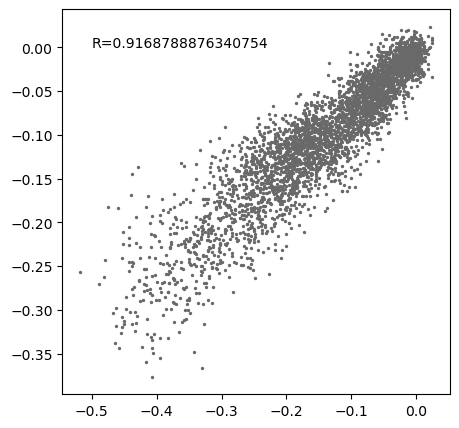

In [54]:
## Display scatterplots of the comparison between phenotypes called for genes in the overlap between validlib and
## original gimap 

plt.figure(figsize=(5,5))
plt.scatter(upperTriangle(og_dmso1_phenotypes.loc[intersect2,intersect2]),
            upperTriangle(dmso_phenotypes.loc[intersect2,intersect2]),
            s=2,
           color = 'dimgray')

plt.text(-0.5,0,
         'R='+str(sp.stats.pearsonr(upperTriangle(og_dmso1_phenotypes.loc[intersect2,intersect2]),
                                    upperTriangle(dmso_phenotypes.loc[intersect2,intersect2]))[0]))


Text(-1.0, 0.3, 'R=0.8540318536395304')

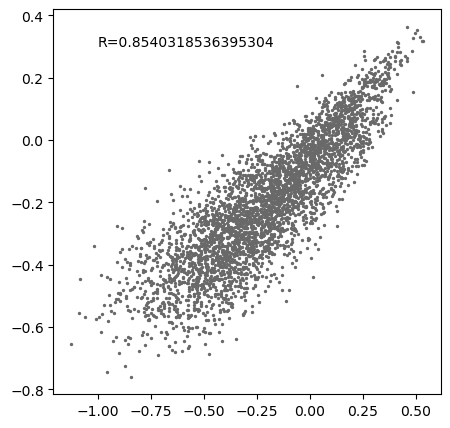

In [55]:
plt.figure(figsize=(5,5))
plt.scatter(upperTriangle(og_atr_phenotypes.loc[intersect2,intersect2]),
            upperTriangle(atr_phenotypes.loc[intersect2,intersect2]),
            s=2,
           color = 'dimgray')

plt.text(-1.0,0.3,
         'R='+str(sp.stats.pearsonr(upperTriangle(og_atr_phenotypes.loc[intersect2,intersect2]),
                                    upperTriangle(atr_phenotypes.loc[intersect2,intersect2]))[0]))


Text(-1.5, 1.5, 'R=0.6813026414951393')

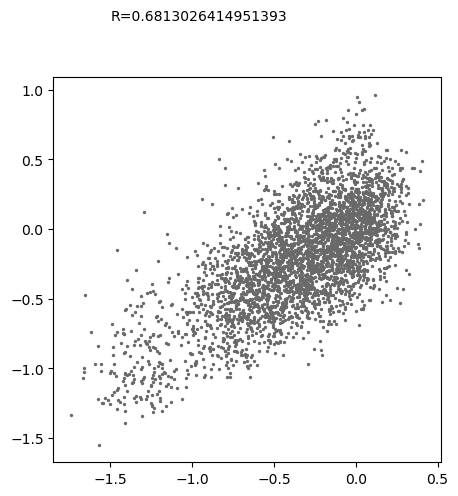

In [56]:
plt.figure(figsize=(5,5))
plt.scatter(upperTriangle(og_etop_phenotypes.loc[intersect2,intersect2]),
            upperTriangle(etop_phenotypes.loc[intersect2,intersect2]),
            s=2,
           color = 'dimgray')

plt.text(-1.5,1.5,
         'R='+str(sp.stats.pearsonr(upperTriangle(og_etop_phenotypes.loc[intersect2,intersect2]),
                                    upperTriangle(etop_phenotypes.loc[intersect2,intersect2]))[0]))


Text(-0.6, 0, 'R=0.7936781977753138')

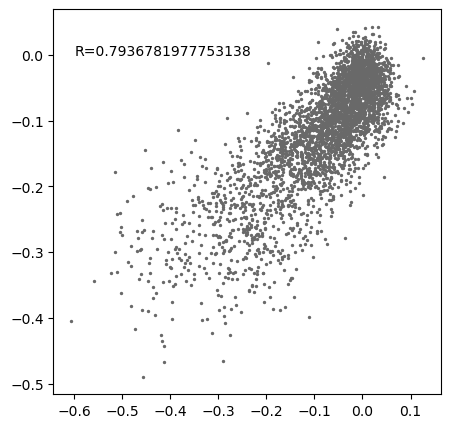

In [57]:
plt.figure(figsize=(5,5))
plt.scatter(upperTriangle(og_keto_phenotypes.loc[intersect2,intersect2]),
            upperTriangle(keto_phenotypes.loc[intersect2,intersect2]),
            s=2,
           color = 'dimgray')

plt.text(-0.6,0,
         'R='+str(sp.stats.pearsonr(upperTriangle(og_keto_phenotypes.loc[intersect2,intersect2]),
                                    upperTriangle(keto_phenotypes.loc[intersect2,intersect2]))[0]))


In [60]:
## Compare GI calling between experiments

intersect3 = list(set(validlib_dmso_map.index).intersection(og_dmso1_map.index))

## Focus the 
gl = ['TRRAP','BRD8','MAX']


custom_palette = sns.blend_palette(["dimgray", "lightcoral"], n_colors=10, as_cmap=True)

Text(0, 0.5, 'validation matrix score')

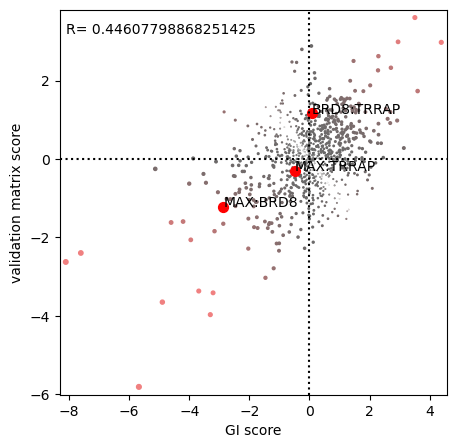

In [63]:
## Make a scatterplot of the interaction scores shared between the validation dmso matrix and the original ref1 eGI map
## highlight gene pairs that agree between conditions with heavier weights, highlight gene pairs with strong scores in pi
## highlight select gene pairs the library was designed around in red, and gives these extra weight. 

plt.figure(figsize=(5,5))
plt.scatter(upperTriangle(og_dmso1_map.loc[intersect3,intersect3]),
            upperTriangle(validlib_dmso_map.loc[intersect3,intersect3]),
           s=abs(upperTriangle(og_dmso1_map.loc[intersect3,intersect3])+
            upperTriangle(validlib_dmso_map.loc[intersect3,intersect3])),
            c = abs(upperTriangle(og_dmso1_map.loc[intersect3,intersect3])*
            upperTriangle(validlib_dmso_map.loc[intersect3,intersect3])),
            vmin = 0,vmax = 10,
           cmap = custom_palette)

plt.scatter(upperTriangle(og_dmso1_map.loc[gl,gl]),
           upperTriangle(validlib_dmso_map.loc[gl,gl]),s=50,
            c = 'red'
            )

plt.text(og_dmso1_map.loc['MAX','TRRAP'],
        validlib_dmso_map.loc['MAX','TRRAP'],'MAX:TRRAP')
plt.text(og_dmso1_map.loc['MAX','BRD8'],
        validlib_dmso_map.loc['MAX','BRD8'],'MAX:BRD8')
plt.text(og_dmso1_map.loc['BRD8','TRRAP'],
        validlib_dmso_map.loc['BRD8','TRRAP'],'BRD8:TRRAP')


plt.text(upperTriangle(og_dmso1_map.loc[intersect3,intersect3]).min(),
         upperTriangle(validlib_dmso_map.loc[intersect3,intersect3]).max()-0.4,
         'R= '+str(sp.stats.pearsonr(upperTriangle(og_dmso1_map.loc[intersect3,intersect3]),
                  upperTriangle(validlib_dmso_map.loc[intersect3,intersect3]))[0]))

plt.plot((upperTriangle(og_dmso1_map.loc[intersect3,intersect3]).min()-0.2,
          upperTriangle(og_dmso1_map.loc[intersect3,intersect3]).max()+0.2),
        (0,0),':',color = 'black')

plt.plot((0,0),
        (upperTriangle(validlib_dmso_map.loc[intersect3,intersect3]).min()-0.2,
         upperTriangle(validlib_dmso_map.loc[intersect3,intersect3]).max()+0.2),':',
         color = 'black')


plt.xlim(upperTriangle(og_dmso1_map.loc[intersect3,intersect3]).min()-0.2,
         upperTriangle(og_dmso1_map.loc[intersect3,intersect3]).max()+0.2)
plt.ylim(upperTriangle(validlib_dmso_map.loc[intersect3,intersect3]).min()-0.2,
         upperTriangle(validlib_dmso_map.loc[intersect3,intersect3]).max()+0.2)

plt.xlabel('GI score')
plt.ylabel('validation matrix score')
#plt.savefig('/Users/benh/Desktop/herken23_main_figs resub/validlib_barplots/dmso_scatter.png',dpi=300)


Text(0, 0.5, 'validation matrix score')

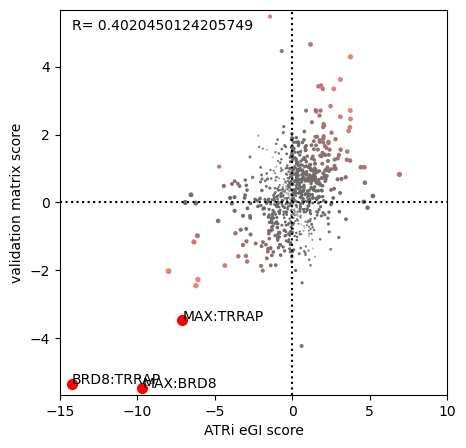

In [62]:
## Make a scatterplot of the interaction scores shared between the validation ATRi matrix and the original ATRi eGI map
## highlight gene pairs that agree between conditions with heavier weights, highlight gene pairs with strong scores in pi
## highlight select gene pairs the library was designed around in red, and gives these extra weight. 

plt.figure(figsize=(5,5))
plt.scatter(upperTriangle(og_atr_map.loc[intersect3,intersect3]),
            upperTriangle(validlib_atr_map.loc[intersect3,intersect3]),
           s=abs(upperTriangle(og_atr_map.loc[intersect3,intersect3])+
            upperTriangle(validlib_atr_map.loc[intersect3,intersect3])),
            c = abs(upperTriangle(og_atr_map.loc[intersect3,intersect3])*
            upperTriangle(validlib_atr_map.loc[intersect3,intersect3])),
            vmin = 0,vmax = 10,
           cmap = custom_palette)

plt.scatter(upperTriangle(og_atr_map.loc[gl,gl]),
           upperTriangle(validlib_atr_map.loc[gl,gl]),s=50,
            c = 'red'
            )

plt.text(og_atr_map.loc['MAX','TRRAP'],
        validlib_atr_map.loc['MAX','TRRAP'],'MAX:TRRAP')
plt.text(og_atr_map.loc['MAX','BRD8'],
        validlib_atr_map.loc['MAX','BRD8'],'MAX:BRD8')
plt.text(og_atr_map.loc['BRD8','TRRAP'],
        validlib_atr_map.loc['BRD8','TRRAP'],'BRD8:TRRAP')



plt.text(upperTriangle(og_atr_map.loc[intersect3,intersect3]).min(),
         upperTriangle(validlib_atr_map.loc[intersect3,intersect3]).max()-0.4,
         'R= '+str(sp.stats.pearsonr(upperTriangle(og_atr_map.loc[intersect3,intersect3]),
                  upperTriangle(validlib_atr_map.loc[intersect3,intersect3]))[0]))

#plt.plot((upperTriangle(og_atr_map.loc[intersect3,intersect3]).min()-0.2,
 #         upperTriangle(og_atr_map.loc[intersect3,intersect3]).max()+0.2),
  #      (0,0),':',color = 'black')
plt.plot((-15,10),
        (0,0),':',color = 'black')

plt.plot((0,0),
        (upperTriangle(validlib_atr_map.loc[intersect3,intersect3]).min()-0.2,
         upperTriangle(validlib_atr_map.loc[intersect3,intersect3]).max()+0.2),':',
         color = 'black')


#plt.xlim(upperTriangle(og_atr_map.loc[intersect3,intersect3]).min()-0.5,
 #        upperTriangle(og_atr_map.loc[intersect3,intersect3]).max()+0.2)
plt.xlim(-15,10)
plt.ylim(upperTriangle(validlib_atr_map.loc[intersect3,intersect3]).min()-0.2,
         upperTriangle(validlib_atr_map.loc[intersect3,intersect3]).max()+0.2)


plt.xlabel('ATRi eGI score')
plt.ylabel('validation matrix score')


#plt.savefig('/Users/benh/Desktop/herken23_main_figs resub/validlib_barplots/atr_scatter.png',dpi=300)

In [34]:
np.hstack(dmso_phenotypes.loc[atr_singles[atr_singles_table['gene'] == gene1].index,
                   atr_singles[atr_singles_table['gene'] == gene2].index].values).std()

0.035969796252781926

/var/folders/wj/l9cwkbvn3f3b12_8zbvnd4500000gp/T/ipykernel_46654/2049599173.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(guide_names,rotation=90)
/var/folders/wj/l9cwkbvn3f3b12_8zbvnd4500000gp/T/ipykernel_46654/2049599173.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(guide_names,rotation=90)


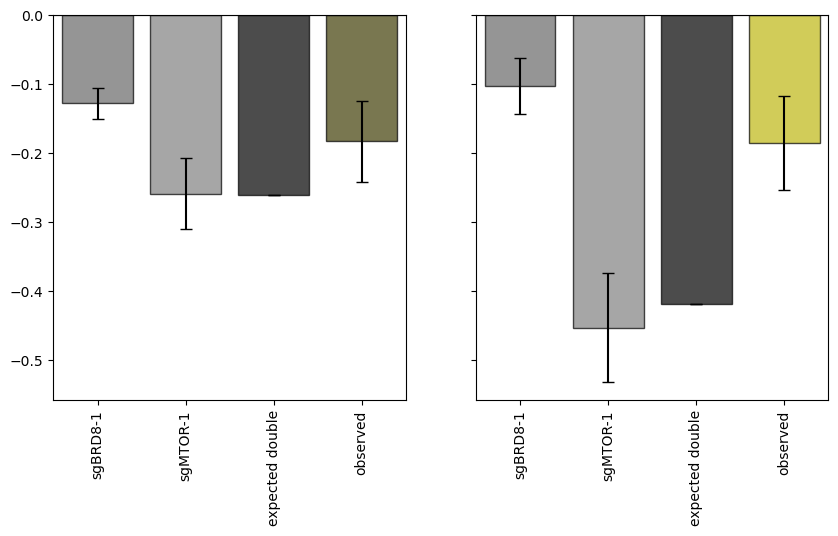

In [64]:
## Make a bar chart of the phenotypes between two guides to illustrate validation of an interaction from the atr map

## Define two genes to query
gene1 = 'GAB2'
gene2 = 'MTOR'

## Select the two guides we'll be comparing
guide1 = atr_singles[atr_singles_table['gene'] == gene1].index[1]
guide2 = atr_singles[atr_singles_table['gene'] == gene2].index[0]

## Make a list with the guide names to be displayed on the bar chart
guide_names = ['sgBRD8-1','sgMTOR-1','expected double','observed']

## Generate models for the two guides selected for both the dmso map...
x1,y1,b1 = getXYB(guide1,dmso_singles,dmso_phenotypes,'b','a')
dmso_fit1 = quadFitForceIntercept(x1,y1,b1)
x2,y2,b2 = getXYB(guide2,dmso_singles,dmso_phenotypes,'b','a')
dmso_fit2 = quadFitForceIntercept(x2,y2,b2)

## and the atr map
x3,y3,b3 = getXYB(guide1,atr_singles,atr_phenotypes,'b','a')
atr_fit1 = quadFitForceIntercept(x3,y3,b3)
x4,y4,b4 = getXYB(guide2,atr_singles,atr_phenotypes,'b','a')
atr_fit2 = quadFitForceIntercept(x4,y4,b4)

## Make lists to be filled with the single phenotypes of the guides in both conditions as well as the 
## associated errors

dmso_bar_phenotypes = []
dmso_bar_err = []
atr_bar_phenotypes = []
atr_bar_err = []

dmso_bar_phenotypes.append(dmso_singles.loc[guide1,'b.mean'])
atr_bar_phenotypes.append(atr_singles.loc[guide1,'b.mean'])
dmso_bar_err.append(dmso_singles.loc[guide1,'b.std'])
atr_bar_err.append(atr_singles.loc[guide1,'b.std'])

dmso_bar_phenotypes.append(dmso_singles.loc[guide2,'b.mean'])
atr_bar_phenotypes.append(atr_singles.loc[guide2,'b.mean'])
dmso_bar_err.append(dmso_singles.loc[guide2,'b.std'])
atr_bar_err.append(atr_singles.loc[guide2,'b.std'])

## Next, append the model predicted double phenotype. These have no error calculation so just fill with zero
dmso_bar_phenotypes.append(np.mean((dmso_fit1(dmso_singles.loc[guide2,'b.mean']),dmso_fit2(dmso_singles.loc[guide1,'b.mean']))))
atr_bar_phenotypes.append(np.mean((atr_fit1(atr_singles.loc[guide2,'b.mean']),atr_fit2(atr_singles.loc[guide1,'b.mean']))))
dmso_bar_err.append(0)
atr_bar_err.append(0)

## Finally append the double phenotypes. We're going to average all paired guide phenotypes for the given gene-gene
## comparison for purposes of the error calculation
dmso_bar_phenotypes.append(dmso_phenotypes.loc[guide1,guide2])
atr_bar_phenotypes.append(atr_phenotypes.loc[guide1,guide2])
dmso_bar_err.append(np.hstack(dmso_phenotypes.loc[atr_singles[atr_singles_table['gene'] == gene1].index,
                   atr_singles[atr_singles_table['gene'] == gene2].index].values).std())
atr_bar_err.append(np.hstack(atr_phenotypes.loc[atr_singles[atr_singles_table['gene'] == gene1].index,
                   atr_singles[atr_singles_table['gene'] == gene2].index].values).std())


## Set up a color map and scale for plotting GIs
cmap = blue_yellow
norm = plt.Normalize(vmin=-0.3, vmax=0.3)
scalar_map = plt.cm.ScalarMappable(norm=norm, cmap=cmap)


## Make two plots, one for the dmso condition and one for ATRi
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

## Plot the bar chart for the dmso condition.
ax1.bar(guide_names,dmso_bar_phenotypes,
        yerr = dmso_bar_err,
        color =('dimgray','gray','black',scalar_map.to_rgba(dmso_bar_phenotypes[3] - dmso_bar_phenotypes[2])),
       edgecolor = 'black',
        capsize = 4,
       alpha = 0.7)
ax1.set_ylabel('')
ax1.set_xlim(-0.5,3.5)
ax1.plot((-1,4),(0,0),color = 'black')
ax1.set_xticklabels(guide_names,rotation=90)

## Plot the bar chart for the ATRi condition.
ax2.bar(guide_names,atr_bar_phenotypes,
       yerr = atr_bar_err,
       color =('dimgray','gray','black',scalar_map.to_rgba(atr_bar_phenotypes[3] - atr_bar_phenotypes[2])),
       edgecolor = 'black',
        capsize = 4,
       alpha = 0.7)
ax2.set_ylabel('')
ax2.set_xlim(-0.5,3.5)

ax2.set_xticklabels(guide_names,rotation=90)
ax2.plot((-1,4),(0,0),color = 'black')


/var/folders/wj/l9cwkbvn3f3b12_8zbvnd4500000gp/T/ipykernel_46654/2707392475.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(guide_names,rotation=90)
/var/folders/wj/l9cwkbvn3f3b12_8zbvnd4500000gp/T/ipykernel_46654/2707392475.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(guide_names,rotation=90)


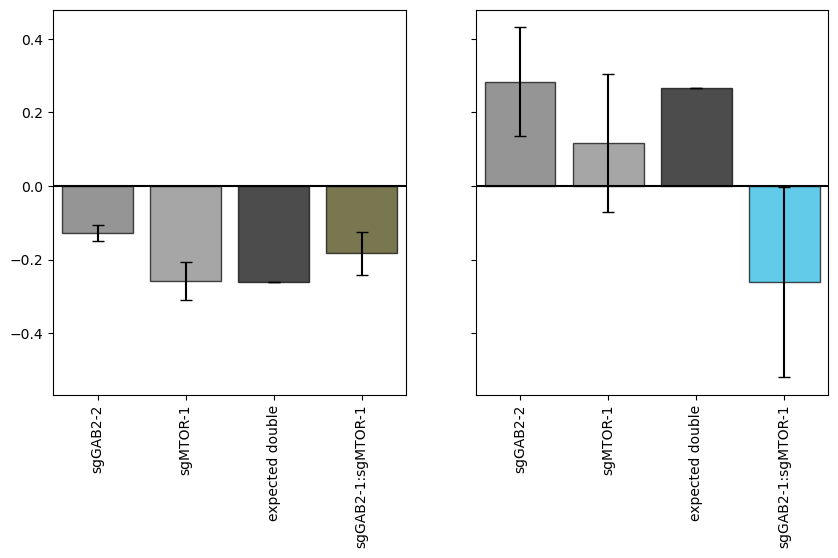

In [65]:
## Make a bar chart of the phenotypes between two guides to illustrate validation of an interaction from the
## etoposide map
gene1 = 'GAB2'
gene2 = 'MTOR'
## Select the two guides we'll be comparing
guide1 = etop_singles[etop_singles_table['gene'] == gene1].index[1]
guide2 = etop_singles[etop_singles_table['gene'] == gene2].index[0]

## Make a list with the guide names to be displayed on the bar chart
guide_names = ['sgGAB2-2','sgMTOR-1','expected double','sgGAB2-1:sgMTOR-1']

## Generate models for the two guides selected for both the dmso map...
x1,y1,b1 = getXYB(guide1,dmso_singles,dmso_phenotypes,'b','a')
dmso_fit1 = quadFitForceIntercept(x1,y1,b1)
x2,y2,b2 = getXYB(guide2,dmso_singles,dmso_phenotypes,'b','a')
dmso_fit2 = quadFitForceIntercept(x2,y2,b2)

## and the Etoposide map
x3,y3,b3 = getXYB(guide1,etop_singles,etop_phenotypes,'b','a')
etop_fit1 = quadFitForceIntercept(x3,y3,b3)
x4,y4,b4 = getXYB(guide2,etop_singles,etop_phenotypes,'b','a')
etop_fit2 = quadFitForceIntercept(x4,y4,b4)

## Make empty lists to be filled with the single phenotypes of the guides in both conditions as well as the 
## associated errors

dmso_bar_phenotypes = []
dmso_bar_err = []
etop_bar_phenotypes = []
etop_bar_err = []

dmso_bar_phenotypes.append(dmso_singles.loc[guide1,'b.mean'])
etop_bar_phenotypes.append(etop_singles.loc[guide1,'b.mean'])
dmso_bar_err.append(dmso_singles.loc[guide1,'b.std'])
etop_bar_err.append(etop_singles.loc[guide1,'b.std'])

dmso_bar_phenotypes.append(dmso_singles.loc[guide2,'b.mean'])
etop_bar_phenotypes.append(etop_singles.loc[guide2,'b.mean'])
dmso_bar_err.append(dmso_singles.loc[guide2,'b.std'])
etop_bar_err.append(etop_singles.loc[guide2,'b.std'])

## Next, append the model predicted double phenotype. These have no error calculation so just fill with zero
dmso_bar_phenotypes.append(np.mean((dmso_fit1(dmso_singles.loc[guide2,'b.mean']),dmso_fit2(dmso_singles.loc[guide1,'b.mean']))))
etop_bar_phenotypes.append(np.mean((etop_fit1(etop_singles.loc[guide2,'b.mean']),etop_fit2(etop_singles.loc[guide1,'b.mean']))))
dmso_bar_err.append(0)
etop_bar_err.append(0)

## Finally append the double phenotypes. These have no error calculation so just fill with zero
dmso_bar_phenotypes.append(dmso_phenotypes.loc[guide1,guide2])
etop_bar_phenotypes.append(etop_phenotypes.loc[guide1,guide2])
dmso_bar_err.append(np.hstack(dmso_phenotypes.loc[dmso_singles[dmso_singles_table['gene'] == gene1].index,
                   dmso_singles[dmso_singles_table['gene'] == gene2].index].values).std())
etop_bar_err.append(np.hstack(etop_phenotypes.loc[etop_singles[etop_singles_table['gene'] == gene1].index,
                   etop_singles[etop_singles_table['gene'] == gene2].index].values).std())



## Set up a color map and scale for plotting GIs
cmap = blue_yellow
norm = plt.Normalize(vmin=-0.3, vmax=0.3)
scalar_map = plt.cm.ScalarMappable(norm=norm, cmap=cmap)



fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

## Plot the first bar chart for the dmso condition.
ax1.bar(guide_names,dmso_bar_phenotypes,
        yerr = dmso_bar_err,
        color =('dimgray','gray','black',scalar_map.to_rgba(dmso_bar_phenotypes[3] - dmso_bar_phenotypes[2])),
       edgecolor = 'black',
        capsize = 4,
       alpha = 0.7)
ax1.set_ylabel('')
ax1.set_xlim(-0.5,3.5)
ax1.plot((-1,4),(0,0),color = 'black')
ax1.set_xticklabels(guide_names,rotation=90)

ax2.bar(guide_names,etop_bar_phenotypes,
       yerr = etop_bar_err,
       color =('dimgray','gray','black',scalar_map.to_rgba(etop_bar_phenotypes[3] - etop_bar_phenotypes[2])),
       edgecolor = 'black',
        capsize = 4,
       alpha = 0.7)
ax2.set_ylabel('')
ax2.set_xlim(-0.5,3.5)

ax2.set_xticklabels(guide_names,rotation=90)
ax2.plot((-1,4),(0,0),color = 'black')



/var/folders/wj/l9cwkbvn3f3b12_8zbvnd4500000gp/T/ipykernel_46654/3481663599.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(guide_names,rotation=90)
/var/folders/wj/l9cwkbvn3f3b12_8zbvnd4500000gp/T/ipykernel_46654/3481663599.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(guide_names,rotation=90)


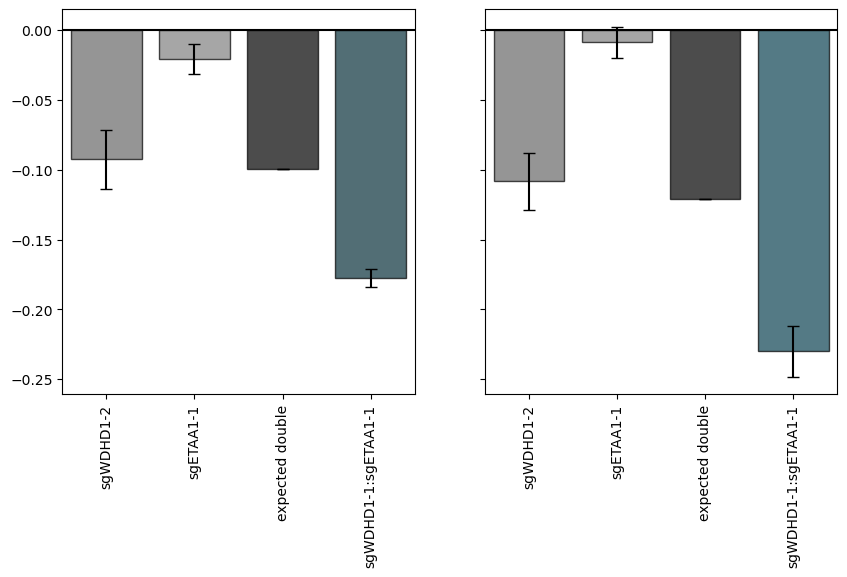

In [67]:
## Make a bar chart of the phenotypes between two guides to illustrate validation of an interaction from the
## glucose deprivation map

gene1 = 'WDHD1'
gene2 = 'ETAA1'
## Select the two guides we'll be comparing
guide1 = keto_singles[keto_singles_table['gene'] == gene1].index[1]
guide2 = keto_singles[keto_singles_table['gene'] == gene2].index[1]

## Make a list with the guide names to be displayed on the bar chart
guide_names = ['sgWDHD1-2','sgETAA1-1','expected double','sgWDHD1-1:sgETAA1-1']

## Generate models for the two guides selected for both the dmso map...
x1,y1,b1 = getXYB(guide1,dmso_singles,dmso_phenotypes,'b','a')
dmso_fit1 = quadFitForceIntercept(x1,y1,b1)
x2,y2,b2 = getXYB(guide2,dmso_singles,dmso_phenotypes,'b','a')
dmso_fit2 = quadFitForceIntercept(x2,y2,b2)

## and the keto map
x3,y3,b3 = getXYB(guide1,keto_singles,keto_phenotypes,'b','a')
keto_fit1 = quadFitForceIntercept(x3,y3,b3)
x4,y4,b4 = getXYB(guide2,keto_singles,keto_phenotypes,'b','a')
keto_fit2 = quadFitForceIntercept(x4,y4,b4)

## Make empty lists to be filled with the single phenotypes of the guides in both conditions as well as the 
## associated errors

dmso_bar_phenotypes = []
dmso_bar_err = []
keto_bar_phenotypes = []
keto_bar_err = []

dmso_bar_phenotypes.append(dmso_singles.loc[guide1,'b.mean'])
keto_bar_phenotypes.append(keto_singles.loc[guide1,'b.mean'])
dmso_bar_err.append(dmso_singles.loc[guide1,'b.std'])
keto_bar_err.append(keto_singles.loc[guide1,'b.std'])

dmso_bar_phenotypes.append(dmso_singles.loc[guide2,'b.mean'])
keto_bar_phenotypes.append(keto_singles.loc[guide2,'b.mean'])
dmso_bar_err.append(dmso_singles.loc[guide2,'b.std'])
keto_bar_err.append(keto_singles.loc[guide2,'b.std'])

## Next, append the model predicted double phenotype. These have no error calculation so just fill with zero
dmso_bar_phenotypes.append(np.mean((dmso_fit1(dmso_singles.loc[guide2,'b.mean']),dmso_fit2(dmso_singles.loc[guide1,'b.mean']))))
keto_bar_phenotypes.append(np.mean((keto_fit1(keto_singles.loc[guide2,'b.mean']),keto_fit2(keto_singles.loc[guide1,'b.mean']))))
dmso_bar_err.append(0)
keto_bar_err.append(0)

## Finally append the double phenotypes. 
dmso_bar_phenotypes.append(dmso_phenotypes.loc[guide1,guide2])
keto_bar_phenotypes.append(keto_phenotypes.loc[guide1,guide2])
dmso_bar_err.append(np.hstack(dmso_phenotypes.loc[dmso_singles[dmso_singles_table['gene'] == gene1].index,
                   dmso_singles[dmso_singles_table['gene'] == gene2].index].values).std())
keto_bar_err.append(np.hstack(keto_phenotypes.loc[keto_singles[keto_singles_table['gene'] == gene1].index,
                   keto_singles[keto_singles_table['gene'] == gene2].index].values).std())



## Set up a color map and scale for plotting GIs
cmap = blue_yellow
norm = plt.Normalize(vmin=-0.3, vmax=0.3)
scalar_map = plt.cm.ScalarMappable(norm=norm, cmap=cmap)



fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

## Plot the first bar chart for the dmso condition.
ax1.bar(guide_names,dmso_bar_phenotypes,
        yerr = dmso_bar_err,
        color =('dimgray','gray','black',scalar_map.to_rgba(dmso_bar_phenotypes[3] - dmso_bar_phenotypes[2])),
       edgecolor = 'black',
        capsize = 4,
       alpha = 0.7)
ax1.set_ylabel('')
ax1.set_xlim(-0.5,3.5)
ax1.plot((-1,4),(0,0),color = 'black')
ax1.set_xticklabels(guide_names,rotation=90)

ax2.bar(guide_names,keto_bar_phenotypes,
       yerr = keto_bar_err,
       color =('dimgray','gray','black',scalar_map.to_rgba(keto_bar_phenotypes[3] - keto_bar_phenotypes[2])),
       edgecolor = 'black',
        capsize = 4,
       alpha = 0.7)
ax2.set_ylabel('')
ax2.set_xlim(-0.5,3.5)

ax2.set_xticklabels(guide_names,rotation=90)
ax2.plot((-1,4),(0,0),color = 'black')
